In [1]:
import righor
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np

# load the model
igor_model = righor.load_model("human", "trb")

# alternatively, you can load a model from igor files 
# igor_model = righor.load_model_from_files(params.txt, marginals.txt, anchor_v.csv, anchor_j.csv)

In [2]:
err_ps = (np.cos(10*np.linspace(0, 1, 100))**2)
err_ps /= err_ps.sum()
error_model = righor.ErrorParameters.uniform_error(err_ps, np.linspace(0, 1, 101))
#error_model = righor.ErrorParameters.constant_error(0.2)
igor_model.error = error_model

In [2]:
## Generate sequences

# Create a generator object
generator = igor_model.generator(seed=42) # or igor_model.generator() to run it without a seed

# Generate 10'000 functional sequences (not out-of-frame, no stop codons, right boundaries)
for _ in tqdm(range(10000)):
    # generate_without_errors ignore Igor error model, use "generate" if this is needed
    sequence = generator.generate_without_errors(functional=True)
    if "IGH" in sequence.cdr3_aa:
        print("TRB CDR3 containing \"IGH\":", sequence.cdr3_aa)

print()

# Generate one sequence with a particular V/J genes family 
V_genes = righor.genes_matching("TRBV2", igor_model) # return all the V genes that match TRBV5
J_genes = righor.genes_matching("TRBJ", igor_model) # all the J genes
generator = igor_model.generator(seed=42, available_v=V_genes, available_j=J_genes) 
generation_result = generator.generate(functional=True)
print("Result:")
print(generation_result)
print("Explicit recombination event:")
print(generation_result.recombination_event)

  0%|          | 0/10000 [00:00<?, ?it/s]

TRB CDR3 containing "IGH": CASSEKGGGQIGHSYEQYF

Result:
GenerationResult(
CDR3 (nucletides): TGTGCCAGCATTCGCCACGGGAGGAATGACTATGGCTACACCTTC,
CDR3 (amino-acids): CASIRHGRNDYGYTF,
Full sequence (nucleotides): GAACCTGAAGTCACCCAGACTCCCAGCCAT...,
V gene: TRBV2*01,
J gene: TRBJ1-2*01)
		 
Explicit recombination event:
StaticEvent(
nb. del. on V3: 11,
nb. del. on D5: 13,
nb. del. on D3: 8,
nb. del. on J5: 7,
V-D insertions: TTCGCCAC,
D-J insertions: AGGAATG,
errors: S66CS105TS121GS196A)


In [3]:
## Evaluate a given sequence
%env RUST_BACKTRACE=1
my_sequence = "ACCCTCCAGTCTGCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCAGTGAGGACAGGGACGTCACTGAAGCTTTCTTTGGACAAGGCACC"

# evaluate the sequence
result_inference = igor_model.evaluate(my_sequence)

# Most likely scenario
best_event = result_inference.best_event

print(f"Probability that this specific event chain created the sequence: {best_event.likelihood / result_inference.likelihood:.2f}.")
print(f"Reconstructed sequence (without errors):", best_event.reconstructed_sequence)
print(f"Pgen: {result_inference.pgen:.1e}")

env: RUST_BACKTRACE=1
Probability that this specific event chain created the sequence: 0.41.
Reconstructed sequence (without errors): GAAGCTGACATCTACCAGACCCCAAGATACCTTGTTATAGGGACAGGAAAGAAGATCACTCTGGAATGTTCTCAAACCATGGGCCATGACAAAATGTACTGGTATCAACAAGATCCAGGAATGGAACTACACCTCATCCACTATTCCTATGGAGTTAATTCCACAGAGAAGGGAGATCTTTCCTCTGAGTCAACAGTCTCCAGAATAAGGACGGAGCATTTTCCCCTGACCCTGGAGTCTGCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCAGTGAGGACAGGGACGTCACTGAAGCTTTCTTTGGACAAGGCACCAGACTCACAGTTGTAG
Pgen: 2.6e-11


In [4]:
# Inference of a model 
# use a very small number of sequences to keep short (still takes a few minutes)

# here we just generate the sequences needed
generator = igor_model.generator()
example_seq = generator.generate(False)
sequences = [generator.generate(False).full_seq for _ in range(500)]

# define parameters for the alignment and the inference (also possible for the evaluation)
align_params = righor.AlignmentParameters()
align_params.left_v_cutoff = 70
infer_params = righor.InferenceParameters()

# generate an uniform model as a starting point 
# (it's generally *much* faster to start from an already inferred model)
model = igor_model.copy().uniform()

# align multiple sequences at once
aligned_sequences = model.align_all_sequences(sequences, align_params)

# multiple round of expectation-maximization to infer the model
models = {}
model = igor_model.uniform()
models[0] = model
for ii in tqdm(range(35)):
    models[ii+1] = models[ii].copy()
    models[ii+1].infer(aligned_sequences, infer_params)

  0%|          | 0/35 [00:00<?, ?it/s]

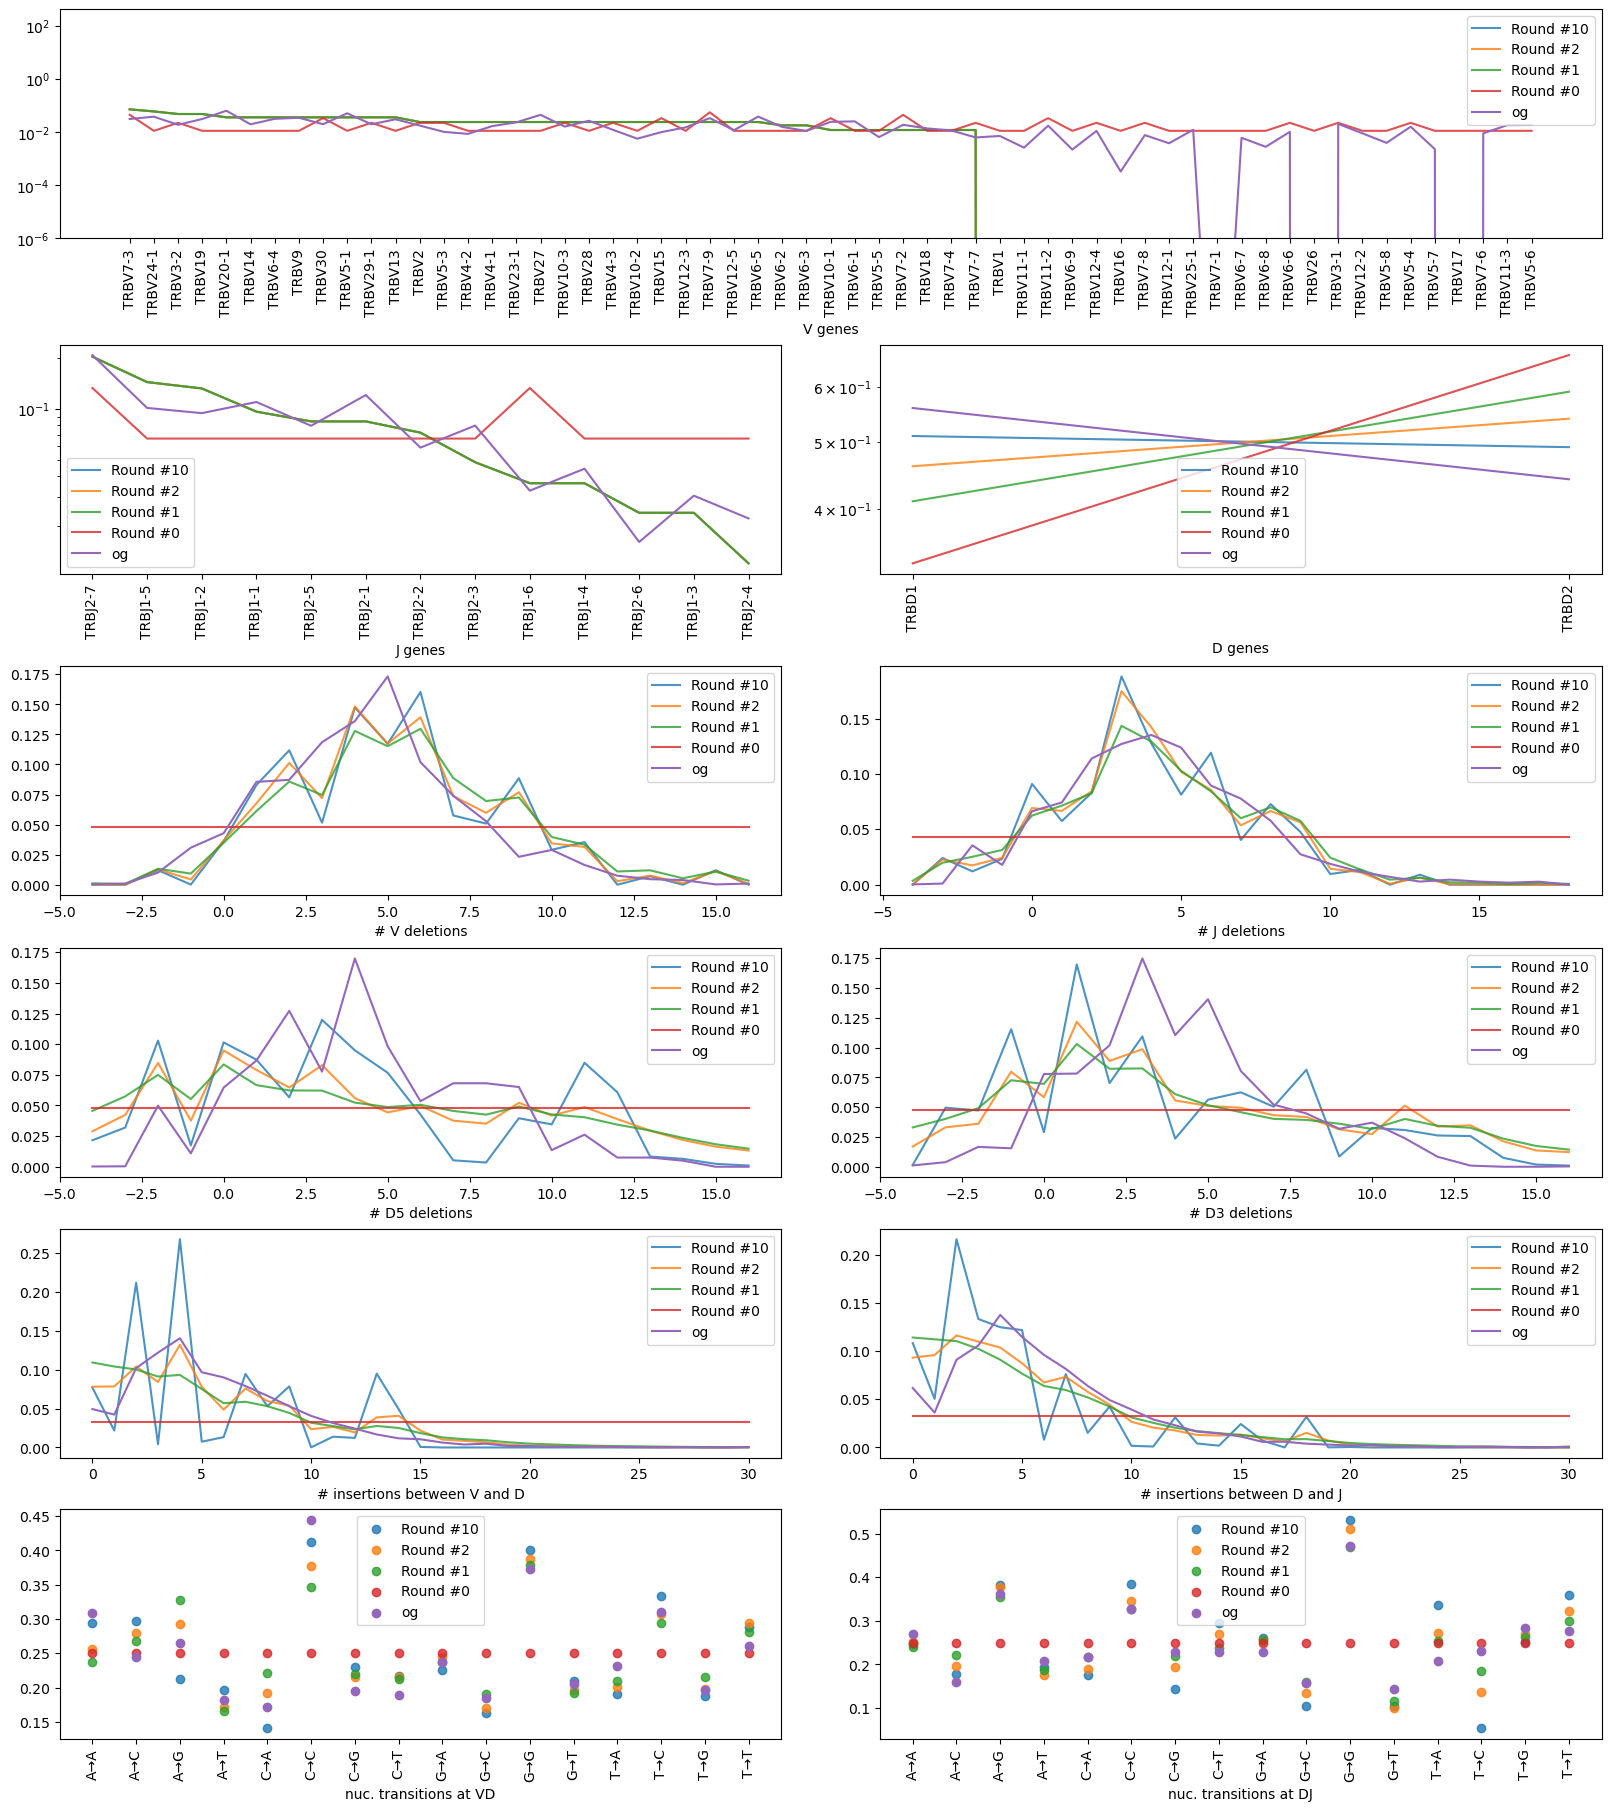

In [9]:
# visualisation of the results
fig = righor.plot_vdj(*[models[ii] for ii in [10, 2, 1, 0]] + [igor_model],
            plots_kws=[{'label':f'Round #{ii}', 'alpha':0.8} for ii in [10,2, 1, 0]] + [{'label':f'og'}] )


In [ ]:
righor.vdj.Model.load_model_from_files

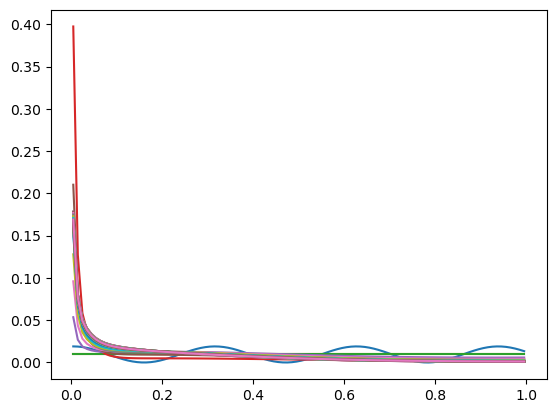

In [13]:
bins, probas = igor_model.error.probability_distribution
plt.plot([(bins[ii] + bins[ii+1])/2 for ii in range(len(probas))], probas)


bins, probas = model.error.probability_distribution
plt.plot([(bins[ii] + bins[ii+1])/2 for ii in range(len(probas))], probas)


for ii in range(35):
    bins, probas = models[ii].error.probability_distribution
    plt.plot([(bins[ii] + bins[ii+1])/2 for ii in range(len(probas))], probas)

In [9]:
# save the model in the Igor format
# will return an error if the directory already exists
models[10].save_model('test_save')
# load the model
igor_model = righor.vdj.Model.load_model_from_files('test_save/model_params.txt',
                                          'test_save/model_marginals.txt',
                                          'test_save/V_gene_CDR3_anchors.csv',
                                          'test_save/J_gene_CDR3_anchors.csv')

# save the model in json format (one file)
models[10].save_json('test_save.json')
# load the model in json
igor_model = righor.vdj.Model.load_json('test_save.json')